# Environment
Let's start by installing the required libraries

In [ ]:
! pip install --quiet langchain langchain_cohere langchain_experimental

## Setup
We'll need a Cohere API key here. Grab your key and paste it in the next slide if you have one, or [register](https://dashboard.cohere.ai/welcome/register) and create a new API key.

In [ ]:
### LLMs
import os
os.environ['COHERE_API_KEY'] = "<INSERT COHERE API KEY HERE>"

In [ ]:
# Create the Cohere chat model
from langchain_cohere.chat_models import ChatCohere
chat = ChatCohere(model="command-r-plus", temperature=0)

# Define tools
Our simple data analyst will be equipped with a web search tool, and a python interpreter (which we can use to run plotting code, for example).

### Web search
Let's first equip our agent with web search! We can use the Tivaly API for this. Head on to [tavily.com](https://tavily.com) and grab an API key to use here.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = "<INSERT TAVILY API KEY HERE>"

internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."


from langchain_core.pydantic_v1 import BaseModel, Field
class TavilySearchInput(BaseModel):
    query: str = Field(description="Query to search the internet with")
internet_search.args_schema = TavilySearchInput

### Python interpreter tool
Let's equip our agent with a python interpreter!

In [ ]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

# from langchain_core.pydantic_v1 import BaseModel, Field
class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput


# Create ReAct Agent: the data analyst

In [ ]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)

# Let's ask a question to the data analyst



> Entering new AgentExecutor chain...

First, I will search for the three tech companies with the highest market cap in the US in 2024. Then, I will search for the number of full-time employees at each of these companies, and plot the data using Python.
{'tool_name': 'internet_search', 'parameters': {'query': 'top 3 tech companies highest market cap US 2024'}}
[{'url': 'https://www.fool.com/research/largest-companies-by-market-cap/', 'content': "It's the most valuable automaker in the world and has the world's best-selling car in the Model Y.\nTesla is most famous for its vehicles, and it's second only to China's BYD Company (OTC:BYDDY) among the largest EV companies in terms of manufacturing. While it's most famous for Windows, Microsoft also has a diverse selection of products and services that has helped to build on its success, including:\nMicrosoft has been the world's largest company before, and it briefly surpassed Apple for the biggest market cap in 2021. Walmart\nWalmart (NY

{'input': 'Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.',
 'output': "Here is a plot showing the number of full-time employees at the three US tech companies with the highest market cap in 2024:\n! [Number of Full Time Employees]('tech_companies_market_cap_employees.png')\n\nThe companies with the highest number of full-time employees are Microsoft with 221,000, Apple with 161,000 and NVIDIA with 29,600.",
 'citations': [CohereCitation(start=125, end=201, text="! [Number of Full Time Employees]('tech_companies_market_cap_employees.png')", documents=[{'output': ''}]),
  CohereCitation(start=268, end=277, text='Microsoft', documents=[{'url': 'https://www.financecharts.com/screener/biggest-country-us', 'content': 'Biggest Companies in the US by Market Cap for Apr 2024. The most valuable company in the US is Microsoft (MSFT) with a market cap of $3.159T, followed by Apple (AAPL) and NVIDIA (NVDA). Last 

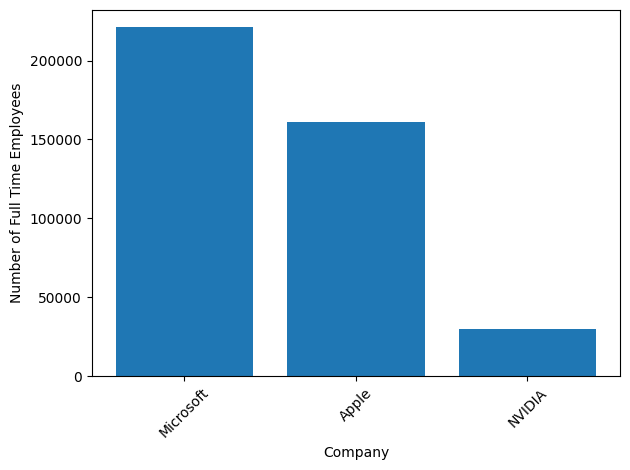

In [ ]:
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.",
})



> Entering new AgentExecutor chain...

First, I will search for the three tech companies with the highest market cap in the US in 2024. Then, I will search for the number of full-time employees at each of these companies and plot the data using Python.
{'tool_name': 'internet_search', 'parameters': {'query': '3 tech companies highest market cap US 2024'}}
[{'url': 'https://www.reuters.com/markets/us/megacap-us-tech-results-pivotal-market-that-is-record-highs-2024-01-23/', 'content': 'Fourth-quarter earnings for S&P 500 companies overall are expected to have increased 4.5% from a year earlier, LSEG data showed on Friday, with a 49% year-over-year earnings gain expected in the ...'}, {'url': 'https://www.forbes.com/advisor/investing/best-tech-stocks/', 'content': 'eToro\nThe Best Tech Stocks of November 2023\nApple Inc. (AAPL)\n$2.8 trillion\n0.5%\n27.1%\n$2.8 trillion\n0.5%\n27.1%\nApple\xa0 was founded in Los Altos, Calif., by Steve Jobs and Steve Wozniak in 1976. ASML Holding NV (AS

{'input': "Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024. On the plot, make sure the y axis ticks have commas so it's easier to read the number of zeros",
 'output': "Here is a plot showing the number of full-time employees at the three tech companies with the highest market cap in the US in 2024:\n\n![Tech Companies Full Time Employees]('tech_companies_full_time_employees.png')\n\nThe companies with the highest number of full-time employees are Microsoft (190,000), Apple (161,000) and NVIDIA (29,600)."}

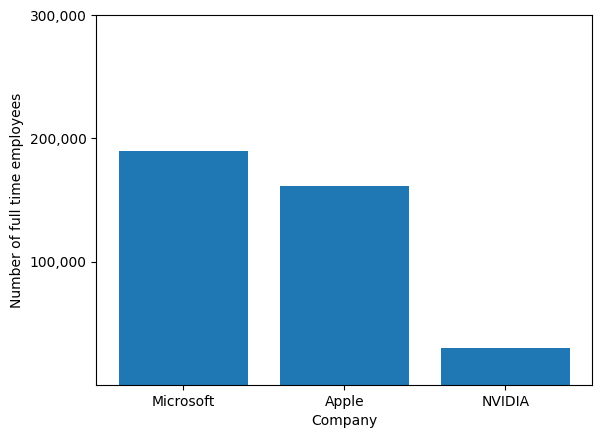

In [ ]:
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024. On the plot, make sure the y axis ticks have commas so it's easier to read the number of zeros",
})

In [ ]:
# notice that the model did websearch calls, then used python to do some analysis
# the model can even self-debug itself if the python code was wrong

# Let's ask another question to the data analyst -- which requires a direct answer

In [ ]:
agent_executor.invoke({
    "input": "Hey how are you?",
})



> Entering new AgentExecutor chain...
Plan: I will respond to the user's greeting.
Action: ```json
[
    {
        "tool_name": "directly_answer",
        "parameters": {}
    }
]
```
Relevant Documents: None
Cited Documents: None
Answer: Hey, I'm doing well, thank you for asking! How can I help you today?
Grounded answer: Hey, I'm doing well, thank you for asking! How can I help you today?

> Finished chain.


{'input': 'Hey how are you?',
 'output': "Hey, I'm doing well, thank you for asking! How can I help you today?",
 'citations': []}

This is a simple example to get you start. There [are many tools](https://python.langchain.com/docs/integrations/tools/) you can equip your agent with. Once youre comfortable with these ideas, you can also proceed to define your tools (see [Multi-step tool use in Action](https://docs.cohere.com/docs/multi-step-tool-use#multi-step-tool-use-in-action)).
